<a href="https://colab.research.google.com/github/sur-sakthy/computer-vision/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset
The provided data has a train/validation split of 1000/500 (approx.) images. In this task you are to select any 4 classes from the original ImageNette data as your working dataset (i.e. classification whereby you are predicting one of four possible classes).

Additionally, you need to reorganise the data into appropriate train/validation/test split before you train your network models. The details of the splitting is left to you, but you must fully justify any final split used in your evaluation.

In [1]:
!cp '/content/drive/MyDrive/EE544 Computer Vision/imagenette2-160.tgz' ./

In [2]:
# remove %%capture command to show output from unzipping
%%capture 
!tar zxvf /content/imagenette2-160.tgz

In [68]:
import os
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, AUC, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
PATH_TO_TRAIN_DATA = '/content/imagenette2-160/train'
PATH_TO_VAL_DATA = '/content/imagenette2-160/val'
IMG_WIDTH=64
IMG_HEIGHT=64

In [5]:
all_classes = os.listdir(PATH_TO_TRAIN_DATA)
all_classes

['n03888257',
 'n02102040',
 'n02979186',
 'n03425413',
 'n03445777',
 'n03000684',
 'n03028079',
 'n03394916',
 'n03417042',
 'n01440764',
 '.DS_Store']

In [6]:
all_classes = os.listdir(PATH_TO_VAL_DATA)
all_classes

['n03888257',
 'n02102040',
 'n02979186',
 'n03425413',
 'n03445777',
 'n03000684',
 'n03028079',
 'n03394916',
 'n03417042',
 'n01440764']

## Load Dataset

In [7]:
data = []
labels = []

In [8]:
def load_dataset(img_folder): 
    for dir in os.listdir(img_folder):
      if dir == 'n03445777' or dir == 'n03417042' or dir == 'n02979186' or dir == 'n03028079' :
        for file in os.listdir(os.path.join(img_folder, dir)):
       
            image_path = os.path.join(img_folder, dir, file)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
            image = np.array(image)
            image = image.astype('float32')
            image /= 255
            data.append(image)
            labels.append(dir)

In [9]:
load_dataset(PATH_TO_TRAIN_DATA)
load_dataset(PATH_TO_VAL_DATA)

In [10]:
np.unique(labels)

array(['n02979186', 'n03028079', 'n03417042', 'n03445777'], dtype='<U9')

In [11]:
data[0].shape

(64, 64, 3)

In [12]:
np.min(data), np.max(data)

(0.0, 1.0)

## Shuffle and split

In [13]:
data, labels = shuffle(data, labels, random_state=0)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.30, random_state=42)

## Class Distribution

In [15]:
df_train = pd.DataFrame(y_train, columns=['label'])
df_train.head()

,label
0,n03028079
1,n02979186
2,n03417042
3,n03445777
4,n03028079


/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


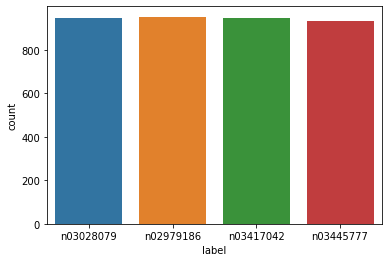

In [63]:
sns.countplot(df_train['label'])
plt.show()

In [17]:
df_test = pd.DataFrame(y_test, columns=['label'])
df_test.head()

,label
0,n03028079
1,n03028079
2,n03028079
3,n03417042
4,n03417042


/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


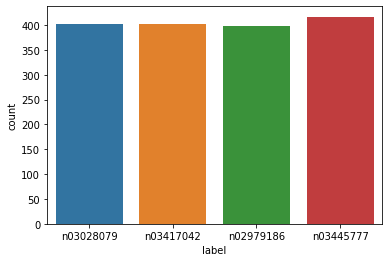

In [64]:
sns.countplot(df_test['label'])
plt.show()

## Encoding

In [19]:
y_train[0]

'n03028079'

In [20]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train = to_categorical(y_train, 4)

In [21]:
y_train[0]

array([0., 1., 0., 0.], dtype=float32)

In [22]:
y_test[0]

'n03028079'

In [23]:
le = LabelEncoder()
y_test = le.fit_transform(y_test)
y_test = to_categorical(y_test, 4)

In [24]:
y_test[0]

array([0., 1., 0., 0.], dtype=float32)

## Create train, validation and test sets

In [25]:
train_datagen = ImageDataGenerator(        
        fill_mode="nearest",
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.1
)

test_datagen = ImageDataGenerator()

In [26]:
train_ds = train_datagen.flow(
  np.array(X_train), y_train,
  subset="training",
  shuffle=True,
  batch_size=20
)

val_ds = train_datagen.flow(
  np.array(X_train), y_train,
  subset="validation",
  shuffle=True,
  batch_size=20
)

test_ds = test_datagen.flow(
  np.array(X_test), y_test,
  shuffle=False,
  batch_size=20
)

## Build model

In [27]:
def build_model(improved=False):
  model = Sequential()

  model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(64,64,3)))
  model.add(Conv2D(32, kernel_size=3, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(64, kernel_size=3, activation='relu'))
  model.add(Conv2D(64, kernel_size=3, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Dense(4, activation='softmax'))

  model.compile(
      optimizer=Adam(),
      loss='categorical_crossentropy',
      metrics=[
          CategoricalAccuracy(),
          Precision(), 
          Recall(),
          AUC()
        ]
  )

  return model

In [28]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                    

## Train model

In [29]:
history = model.fit(
    train_ds,
    epochs=5,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/5
171/171 [==============================] - 94s 535ms/step - loss: 1.1059 - categorical_accuracy: 0.5071 - precision: 0.6683 - recall: 0.2854 - auc: 0.7792 - val_loss: 0.9002 - val_categorical_accuracy: 0.6455 - val_precision: 0.6913 - val_recall: 0.5688 - val_auc: 0.8646
Epoch 2/5
171/171 [==============================] - 96s 562ms/step - loss: 0.8160 - categorical_accuracy: 0.6775 - precision: 0.7572 - recall: 0.5755 - auc: 0.8876 - val_loss: 0.9014 - val_categorical_accuracy: 0.6349 - val_precision: 0.6732 - val_recall: 0.5450 - val_auc: 0.8627
Epoch 3/5
171/171 [==============================] - 92s 539ms/step - loss: 0.7011 - categorical_accuracy: 0.7334 - precision: 0.7940 - recall: 0.6593 - auc: 0.9179 - val_loss: 0.6396 - val_categorical_accuracy: 0.7354 - val_precision: 0.7963 - val_recall: 0.6825 - val_auc: 0.9304
Epoch 4/5
171/171 [==============================] - 91s 532ms/step - loss: 0.6349 - categorical_accuracy: 0.7640 - precision: 0.8161 - recall: 0.7081 - a

## Save weights 

In [30]:
model.save_weights('/content/drive/MyDrive/EE544 Computer Vision/task #1.h5')

## Plot results

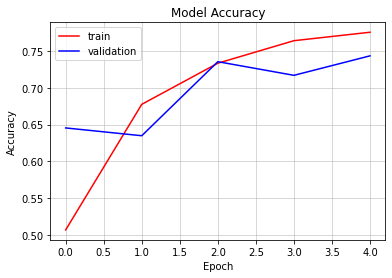

In [38]:
plt.plot(history.history['categorical_accuracy'], color='red', label='train') 
plt.plot(history.history['val_categorical_accuracy'], color='blue', label='validation') 
plt.title('Model Accuracy') 
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend() 
plt.grid(linestyle='-', linewidth=0.5)

In [65]:
eval_results = model.evaluate(test_ds, batch_size=30)

81/81 [==============================] - 11s 138ms/step - loss: 0.5641 - categorical_accuracy: 0.7963 - precision: 0.8226 - recall: 0.7698 - auc: 0.9482


In [66]:
print('Test loss:', eval_results[0])
print('Test categorical_accuracy:', eval_results[1])
print('Test precision:', eval_results[2])
print('Test recall:', eval_results[3])
print('Test auc:', eval_results[4])

Test loss: 0.5641413927078247
Test categorical_accuracy: 0.7962962985038757
Test precision: 0.8225593566894531
Test recall: 0.769753098487854
Test auc: 0.948183000087738


In [46]:
pred = model.predict(test_ds)

81/81 [==============================] - 11s 129ms/step


In [53]:
pred

array([[3.9004426e-05, 9.4360620e-01, 5.6169268e-02, 1.8543187e-04],
       [1.0034263e-03, 9.6597826e-01, 3.1047991e-02, 1.9702618e-03],
       [1.8195745e-02, 6.5639460e-01, 3.1164065e-01, 1.3768984e-02],
       ...,
       [3.6361936e-02, 9.4121359e-02, 2.9498296e-02, 8.4001833e-01],
       [4.7585096e-02, 1.6350539e-03, 9.5032156e-01, 4.5838443e-04],
       [2.5574089e-04, 1.2753207e-04, 2.6750218e-04, 9.9934918e-01]],
      dtype=float32)

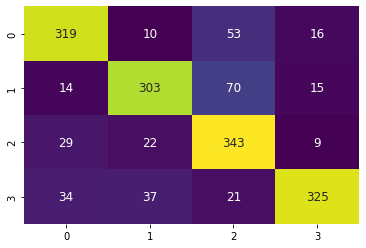

In [57]:
cm = confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1))
sns.heatmap(cm, annot=True, annot_kws={"size": 12}, fmt='g', cbar=False, cmap="viridis")
plt.show()

In [74]:
print(classification_report(y_test.argmax(axis=1), pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.81      0.80      0.80       398
           1       0.81      0.75      0.78       402
           2       0.70      0.85      0.77       403
           3       0.89      0.78      0.83       417

    accuracy                           0.80      1620
   macro avg       0.80      0.80      0.80      1620
weighted avg       0.80      0.80      0.80      1620

